# PyMC3

**Note**

This notebook is a rough first attempt at converting the content of the *VPfits* notebook from PyMC2 to PyMC3. Unfortunately, the implementation shown here is *very* slow, even for the most simple tasks. I'm not sure why, however there is a lot of chatter on the PyMC3 issues board about performance issues compared to PyMC2.

In [1]:
%matplotlib inline
import matplotlib.pylab as pylab

import pymc3 as mc
from theano.tensor import switch

import pandas as pd
import numpy as np
import datetime

## Generate Test Data

In [2]:
def GaussFunction(wavelength_array, amplitude, centroid, sigma, *args, **kwargs):
    return amplitude * np.exp(-0.5 * ((wavelength_array - centroid) / sigma)**2)

def VoigtAbsorption(tau_array):
    return np.exp(-tau_array)

In [3]:
wavelength_array = np.arange(5010, 5030, 0.02) 

In [65]:
clouds = pd.DataFrame({'cloud': pd.Series([], dtype='str'),
                       'amplitude': pd.Series([], dtype='float'),
                       'centroid': pd.Series([], dtype='float'),
                       'sigma': pd.Series([], dtype='float'),
                       'tau': pd.Series([], dtype='object')})

clouds = clouds.append({'cloud': '0', 'amplitude': 0.85, 'centroid': 5017.5, 'sigma': 1.2, 'tau':[]}, ignore_index=True)
clouds = clouds.append({'cloud': '1', 'amplitude': 0.35, 'centroid': 5018.1, 'sigma': 0.7, 'tau':[]}, ignore_index=True)
#clouds = clouds.append({'cloud': '2', 'amplitude': 0.55, 'centroid': 5016.5, 'sigma': 0.9, 'tau':[]}, ignore_index=True)

In [68]:
clouds.set_value(0, 'tau', GaussFunction(wavelength_array, clouds.ix[0]['amplitude'], 
                                         clouds.ix[0]['centroid'], clouds.ix[0]['sigma']))

clouds.set_value(1, 'tau', GaussFunction(wavelength_array, clouds.ix[1]['amplitude'],
                                         clouds.ix[1]['centroid'], clouds.ix[1]['sigma']))

#clouds.set_value(2, 'tau', GaussFunction(wavelength_array, clouds.ix[2]['amplitude'],
#                                         clouds.ix[2]['centroid'], clouds.ix[2]['sigma']))

,amplitude,centroid,cloud,sigma,tau
0,0.85,5017.5,0,1.2,"[2.79965699376e-09, 3.10658696677e-09, 3.44620..."
1,0.35,5018.1,1,0.7,"[2.94100415831e-30, 4.09167800104e-30, 5.68791..."


In [69]:
onesigmaerror = 0.02 
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))

flux_array = VoigtAbsorption(sum(clouds['tau'])) + noise

(0, 1.1)

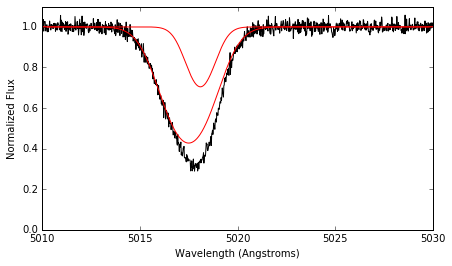

In [71]:
f, ax = pylab.subplots(figsize=(7,4))

ax.plot(wavelength_array, flux_array, color='black', label='flux')

ax.plot(wavelength_array, VoigtAbsorption(clouds.ix[0]['tau']), color='red')
ax.plot(wavelength_array, VoigtAbsorption(clouds.ix[1]['tau']), color='red')
#ax.plot(wavelength_array, VoigtAbsorption(clouds.ix[2]['tau']), color='red')

ax.set_ylabel("Normalized Flux")
ax.set_xlabel("Wavelength (Angstroms)")
ax.set_ylim(0, 1.1)

## Fit Model

In [72]:
basic_model = mc.Model()

with basic_model:
    
    height = mc.Uniform("height", 0, 1)
    centroid = mc.Uniform("centroid", wavelength_array[0], wavelength_array[-1])
    sigma = mc.Uniform("sigma", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    
    sd = 1./mc.Uniform("std", 0, 1)**2
    
    mu = GaussFunction(wavelength_array, height, centroid, sigma)
    
    Y_obs = mc.Normal('Y_obs', mu=mu, sd=sd, observed=flux_array)

In [73]:
with basic_model:

    # obtain starting values via MAP
    start = mc.find_MAP()
    print(start)

    trace = mc.sample(3000, start=start, njobs=-2)

{'centroid_interval_': array(4.508422501386133), 'height_interval_': array(14.591021345985336), 'sigma_interval_': array(17.20128267661244), 'std_interval_': array(2.5338842195349915)}


100%|██████████| 3000/3000 [01:25<00:00, 34.97it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe02115d410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe0208ae050>]], dtype=object)

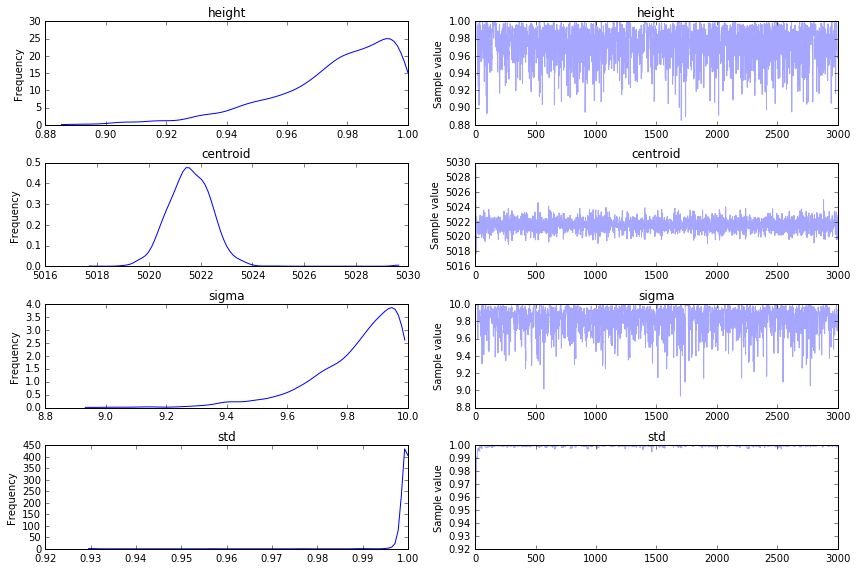

In [75]:
mc.traceplot(trace)

In [76]:
mc.summary(trace)


height:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.975            0.020            0.000            [0.934, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.923          0.965          0.980          0.992          0.999


centroid:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5021.598         0.896            0.021            [5020.013, 5023.185]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  5020.007       5021.040       5021.580       5022.142       5023.183


sigma:

  Mean             SD               MC Error         95% HPD interval
  ------------

In [77]:
mc.stats.dic(model=basic_model, trace=trace)

1965.0228411417982

In [78]:
mc.stats.waic(model=basic_model, trace=trace)

1923.7325463096661

## Compare Models

In [60]:
model_A = mc.Model()
model_B = mc.Model()

with model_A:
    
    height = mc.Uniform("height", 0, 1)
    centroid = mc.Uniform("centroid", wavelength_array[0], wavelength_array[-1])
    sigma = mc.Uniform("sigma", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    
    mu = GaussFunction(wavelength_array, height, centroid, sigma)
    
    sd = 1./mc.Uniform("std", 0, 1)**2
    Y_obs = mc.Normal('Y_obs', mu=VoigtAbsorption(mu), sd=sd, observed=flux_array)
    
    start = mc.find_MAP(fmin=optimize.fmin_powell)
    print(start)

    #trace_A = mc.sample(2000, start=start)
    


{'centroid_interval_': array(-0.5521863305398718), 'height_interval_': array(2.1105276473220402), 'sigma_interval_': array(-1.72478064163097), 'std_interval_': array(7.597193280133413)}


100%|██████████| 3000/3000 [02:37<00:00, 19.01it/s]


In [ ]:
trace_A = model_A.sample(2000, start=start)

In [62]:
with model_B:
    
    height_1 = mc.Uniform("height_1", 0, 1)
    centroid_1 = mc.Uniform("centroid_1", wavelength_array[0], wavelength_array[-1])
    sigma_1 = mc.Uniform("sigma_1", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    
    mu_1 = GaussFunction(wavelength_array, height_1, centroid_1, sigma_1)
    
    height_2 = mc.Uniform("height_2", 0, 1)
    centroid_2 = mc.Uniform("centroid_2", wavelength_array[0], wavelength_array[-1])
    sigma_2 = mc.Uniform("sigma_2", 0, (wavelength_array[-1] - wavelength_array[0])/2)
    
    mu_2 = GaussFunction(wavelength_array, height_2, centroid_2, sigma_2)
    
    sd = 1./mc.Uniform("std", 0, 1)**2
    Y_obs = mc.Normal('Y_obs', mu=VoigtAbsorption(mu_1+mu_2), sd=sd, observed=flux_array)
    
    start = mc.find_MAP()
    print(start)

    trace_B = mc.sample(2000, start=start)

{'sigma_2_interval_': array(-1.8863065579594684), 'std_interval_': array(7.600590351584384), 'centroid_1_interval_': array(-0.5519403039344426), 'centroid_2_interval_': array(-0.5519403204450631), 'sigma_1_interval_': array(-1.8863068128958398), 'height_2_interval_': array(0.5424785184344004), 'height_1_interval_': array(0.5424810383377584)}


100%|██████████| 2000/2000 [05:43<00:00,  5.82it/s]


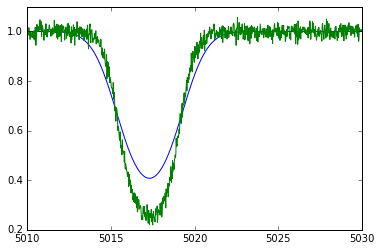

In [61]:
pylab.plot(wavelength_array, VoigtAbsorption(GaussFunction(wavelength_array,
              trace_A.get_values('height').mean(),
              trace_A.get_values('centroid').mean(),
              trace_A.get_values('sigma').mean())))

pylab.plot(wavelength_array, flux_array)

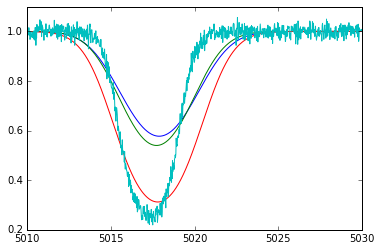

In [64]:
pylab.plot(wavelength_array, VoigtAbsorption(GaussFunction(wavelength_array,
              trace_B.get_values('height_1').mean(),
              trace_B.get_values('centroid_1').mean(),
              trace_B.get_values('sigma_1').mean())))

pylab.plot(wavelength_array, VoigtAbsorption(GaussFunction(wavelength_array,
              trace_B.get_values('height_2').mean(),
              trace_B.get_values('centroid_2').mean(),
              trace_B.get_values('sigma_2').mean())))


pylab.plot(wavelength_array, VoigtAbsorption(GaussFunction(wavelength_array,
              trace_B.get_values('height_2').mean(),
              trace_B.get_values('centroid_2').mean(),
              trace_B.get_values('sigma_2').mean()) + GaussFunction(wavelength_array,
              trace_B.get_values('height_1').mean(),
              trace_B.get_values('centroid_1').mean(),
              trace_B.get_values('sigma_1').mean())))

pylab.plot(wavelength_array, flux_array)

In [ ]:
fit = {}
fit['total'] = np.zeros_like(wavelength_array)

for fitcomponent in range(1, fitComponents+1):
    fit[fitcomponent] = GaussFunction(wavelength_array, 
                                      estimated_variables[fitcomponent]['height'].value,
                                      estimated_variables[fitcomponent]['centroid'].value,
                                      estimated_variables[fitcomponent]['sigma'].value)
    
    fit['total'] += fit[fitcomponent]

In [ ]:
f, (ax1, ax2, ax3) = pylab.subplots(3, sharex=True, sharey=False, figsize=(10,10))

ax1.plot(wavelength_array, (flux_array - VoigtAbsorption(fit['total'])) / onesigmaerror)
ax1.hlines(1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')
ax1.hlines(-1, wavelength_array[0], wavelength_array[-1], color='red', linestyles='-')

ax2.plot(wavelength_array, flux_array, color='black', linewidth=1.0)

for fitcomponent in range(1, fitComponents+1):
    if fitcomponent == 1:
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green", label="Fit")
        ax2.plot(wavelength_array, VoigtAbsorption(clouds.ix[fitcomponent-1]['tau']), color="red", label="Actual")
    else: 
        ax2.plot(wavelength_array, VoigtAbsorption(fit[fitcomponent]), color="green")
        ax2.plot(wavelength_array, VoigtAbsorption(clouds.ix[fitcomponent-1]['tau']), color="red")

ax2.legend()

ax3.plot(wavelength_array, flux_array, label="Measured")
ax3.plot(wavelength_array, VoigtAbsorption(fit['total']), color='green', label="Fit", linewidth=2.0)
ax3.legend()

f.subplots_adjust(hspace=0)

ax1.set_title("Toy Example fit took: " + fit_time)
ax1.set_ylabel("Residuals in sigmas")
ax2.set_ylabel("Fit by component")
ax3.set_ylabel("Total fit to normalized flux")
ax3.set_xlabel("Wavelength (Angstroms)")

## Bayes Factor Demo

In [188]:
with mc.Model() as model:

    # Data
    Y = [0,1,2,3,8]

    # Prior model probabilities
    pi = (0.1, 0.9)

    # Index to true model
    true_model = mc.Bernoulli('true_model', pi[1])

    # Poisson mean
    mu = mc.Uniform('mu', 0, 1000)

    # Geometric probability
    p = 1/(1+mu)

    Ylike = mc.DensityDist('Ylike',
            lambda value: switch(true_model, 
                mc.Poisson.dist(mu).logp(value), 
                mc.Geometric.dist(p).logp(value+1)
            ),
            observed=Y)

    trace = mc.sample(20000, step=mc.Metropolis())

    mc.summary(trace[5000:])
    
    p_pois = trace[5000:]['true_model'].mean()  # mean value (i.e. the rate of poisson samples to all samples)
    BF = ((1-p_pois)/p_pois) * (pi[1]/pi[0])  # BayesFactor in favor of poisson model, taking prior probability into account
    
print p_pois
print BF

100%|██████████| 20000/20000 [00:02<00:00, 7539.85it/s]


true_model:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.401            0.490            0.011            [0.000, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          1.000          1.000


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.184            3.169            0.060            [0.993, 9.457]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.520          2.570          3.331          4.606          12.055

0.400666666667
13.462562396
